# TP3 - Visión por computadora 1

Integrantes:
- Marco Joel Isidro (a1520)
- Diego Sarina (a1519)

Encontrar el logotipo de la gaseosa dentro de las imágenes provistas en `Material_TPs/TP3/images` a partir del template `Material_TPs/TP3/template`.

1. Obtener una detección del logo en cada imagen sin falsos positivos.
2. Plantear y validar un algoritmo para múltiples detecciones en la imagen `coco_multi.png` con el mismo template del ítem 1.
3. Generalizar el algoritmo del ítem 2 para todas las imágenes.

Visualizar los resultados con bounding boxes en cada imagen mostrando el nivel de confianza de la detección.

## Parte 1

1. Obtener una detección del logo en cada imagen sin falsos positivos.


In [1]:
import cv2 as cv
import numpy as np
import os
import matplotlib.pyplot as plt
import math

In [2]:
# definiciones generales
base_path = './enunciado/images/'
image_files_single = ['coca_logo_1.png', 'coca_logo_2.png', 'coca_retro_1.png', 'coca_retro_2.png', 'COCA-COLA-LOGO.jpg', 'logo_1.png']

multi_image = 'coca_multi.png'
# template
template_path = './enunciado/template/pattern.png'

# lista de imagenes a procesar 
full_image_paths = [f"{base_path}{image_path}" for image_path in image_files_single]

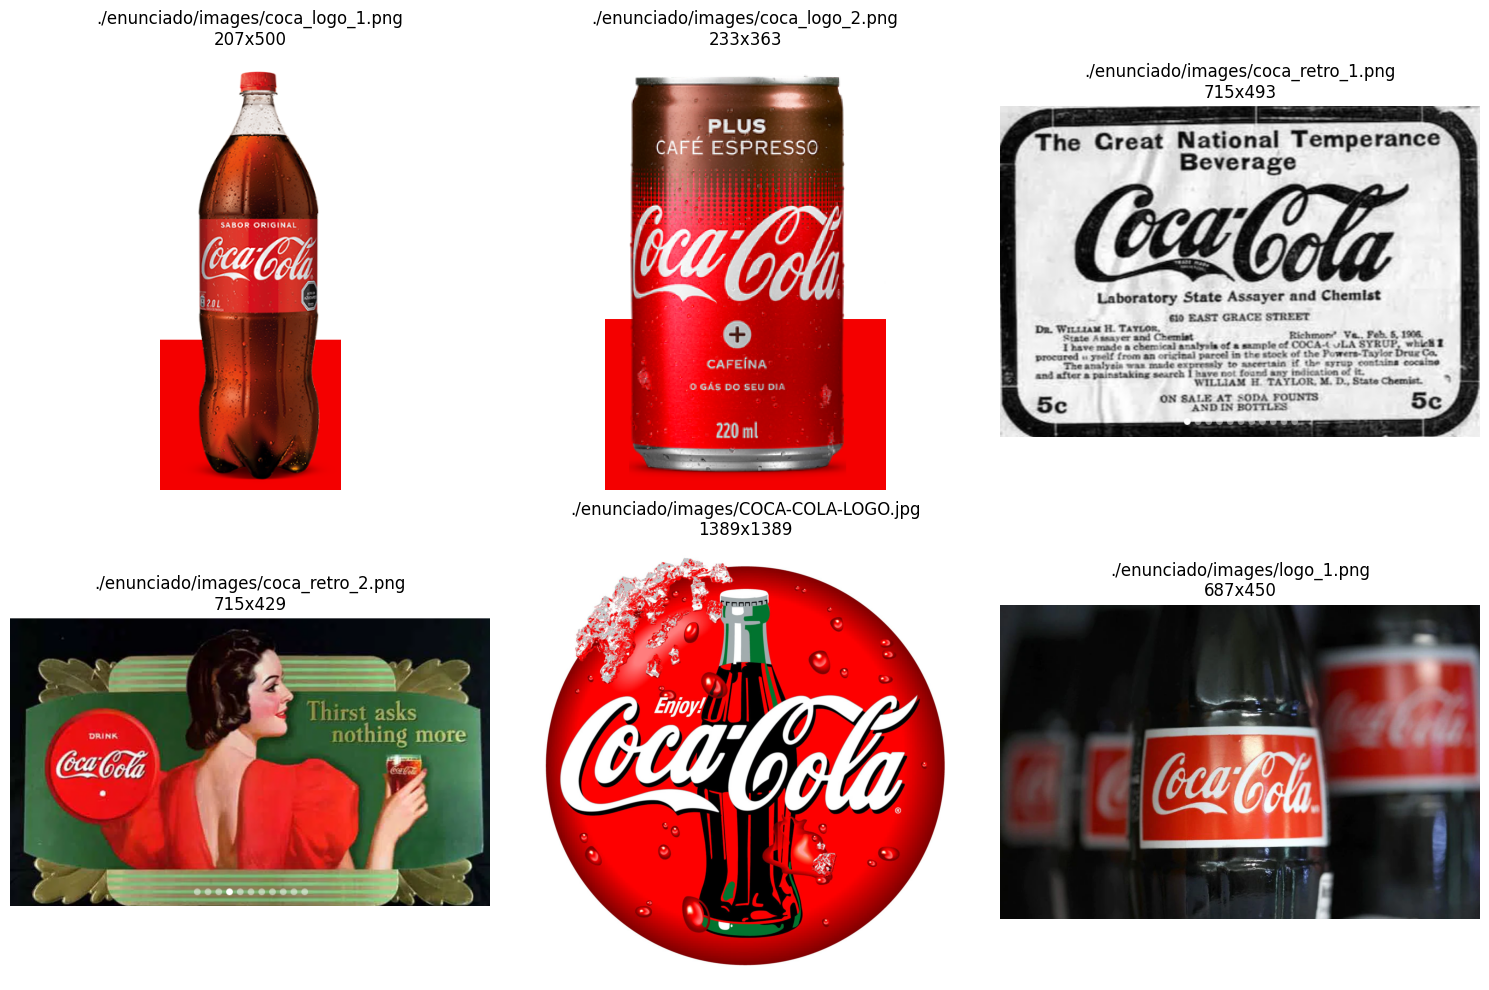

In [3]:
def show_images(image_paths):
    num_images = len(image_paths)
    num_cols = 3
    num_rows = math.ceil(num_images / num_cols)
    
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
    
    for i, img_path in enumerate(image_paths):
        img = cv.imread(img_path)
        if img is not None and not img.size == 0:
            imgRGB = cv.cvtColor(img, cv.COLOR_BGR2RGB)
            height, width = img.shape[:2]
            title = f'{img_path}\n{width}x{height}'
            axs[i // num_cols, i % num_cols].imshow(imgRGB)
            axs[i // num_cols, i % num_cols].set_title(title)
            axs[i // num_cols, i % num_cols].axis('off')
        else:
            print(f"Error: {img_path} está vacía o cargada incorrectamente.")
    
    # Ocultar ejes no utilizados
    for j in range(i + 1, num_rows * num_cols):
        fig.delaxes(axs[j // num_cols, j % num_cols])

    plt.tight_layout()
    plt.show()

# Visalizo las imagenes que tengo que procesar
show_images(full_image_paths)


Dimensiones del template: 400x175


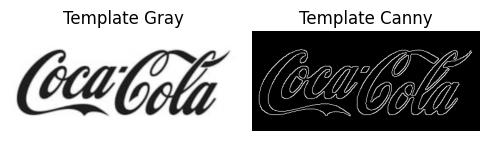

In [4]:
# Cargo el template y lo visualizo
template = cv.imread(template_path)

if template is None:
    raise FileNotFoundError(f"No se pudo cargar el template desde {template_path}")
else:
    template_gray = cv.cvtColor(template, cv.COLOR_BGR2GRAY)
    w, h = template_gray.shape[::-1]
    print(f"Dimensiones del template: {w}x{h}")

# Aplicar Canny al template
template = cv.Canny(template_gray, 50, 200)

# Visualizar el template en escala de grises y con Canny uno al lado del otro
fig, axs = plt.subplots(1, 2, figsize=(5, 5))

axs[0].imshow(template_gray, cmap='gray')
axs[0].set_title('Template Gray')
axs[0].axis('off')

axs[1].imshow(template, cmap='gray')
axs[1].set_title('Template Canny')
axs[1].axis('off')

plt.tight_layout()
plt.show()



Veo que tengo varias diferencias de escala entre las imagenes y el template. Sobre todo tengo un tema con una imagen que es muy grande en comparacion al resto

In [5]:
# Los 6 métodos posibles para comparación:
methods = ['cv.TM_CCOEFF', 'cv.TM_CCOEFF_NORMED', 'cv.TM_CCORR',
            'cv.TM_CCORR_NORMED', 'cv.TM_SQDIFF', 'cv.TM_SQDIFF_NORMED']

In [6]:
# Escalas a probar
scales = [0.35, 3, 2, 1.5, 1, 0.75, 0.5, 0.4, 0.25]

# Función para detectar el logo en las imágenes
def detect_logo_in_images(img_paths, template, methods, scales):
    # Dimensiones del temaplate
    h_template, w_template = template.shape[:2]

    for img_path in img_paths:
        # cargo la imagen
        img = cv.imread(img_path)
        if img is None:
            print(f"No se pudo cargar la imagen desde {img_path}")
            continue

        h_img, w_img = img.shape[:2]
        fig, axs = plt.subplots(1, 6, figsize=(20, 10))
        
        for j, meth in enumerate(methods):
            max_value = []
            max_local = []
            min_value = []
            min_local = []
            used_scales = []
            method = eval(meth)

            for scale in scales:
                # redimensionar la imagen de acuerdo a la escala
                img_rz = cv.resize(img, (int(img.shape[1] * scale), int(img.shape[0] * scale)))
                w_rz, h_rz = img_rz.shape[1], img_rz.shape[0]
                
                # verifico si el tamaño redimensionado es suficiente para el template
                if h_rz < h_template or w_rz < w_template:
                    continue

                image_gray = cv.cvtColor(img_rz, cv.COLOR_BGR2GRAY)
                img_canny = cv.Canny(image_gray, 100, 200)
                

                res = cv.matchTemplate(img_canny, template, method)
                min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)
                
                # almaceno los valores y ubicaciones de acuerdo al método
                if method in [cv.TM_SQDIFF, cv.TM_SQDIFF_NORMED]:
                    min_value.append(min_val)
                    min_local.append(min_loc)
                else:
                    max_value.append(max_val)
                    max_local.append(max_loc)
                used_scales.append(scale)

            # trato de determinar el mejor resultado para el metodo y las listas de valores
            id = np.argmin(min_value) if method in [cv.TM_SQDIFF, cv.TM_SQDIFF_NORMED] else np.argmax(max_value)
            local = min_local[id] if method in [cv.TM_SQDIFF, cv.TM_SQDIFF_NORMED] else max_local[id]
            scale_used = used_scales[id]
            x, y = np.divide(local, scale_used)
            
            # coordenadas del bounding box
            h_rectangle, w_rectangle = np.divide((h_template, w_template), scale_used)
            bottom_right = (int(x + w_rectangle), int(y + h_rectangle))
            top_left = (int(x), int(y))
            
            # bounding box en la imagen
            img_plot = img.copy()
            cv.rectangle(img_plot, top_left, bottom_right, (255, 0, 0), 5)
            
            axs[j].imshow(cv.cvtColor(img_plot, cv.COLOR_BGR2RGB))
            axs[j].set_title(meth)
            axs[j].axis('off')

        plt.suptitle(f'Detecciones en {img_path}')
        plt.show()

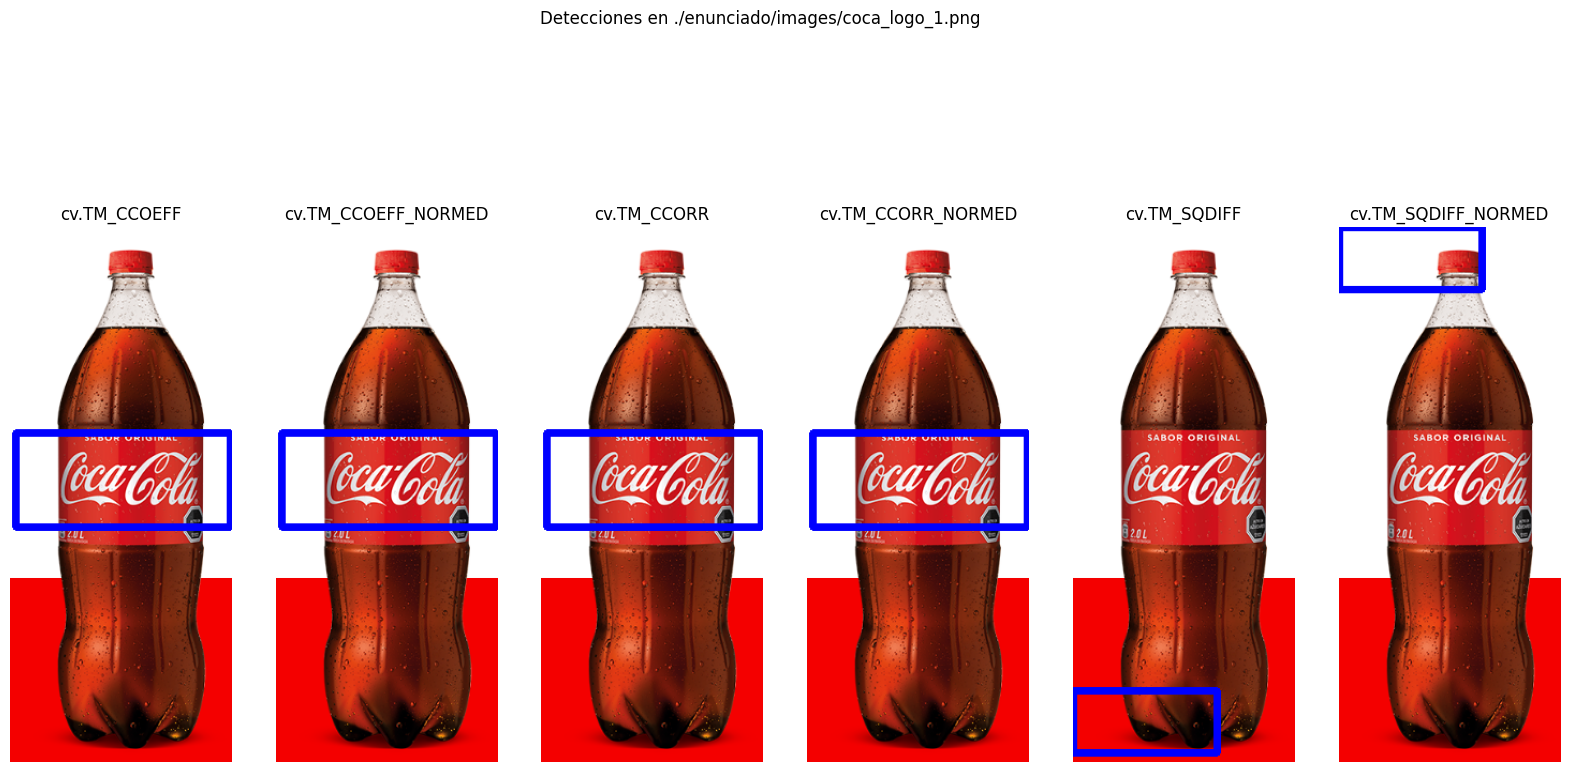

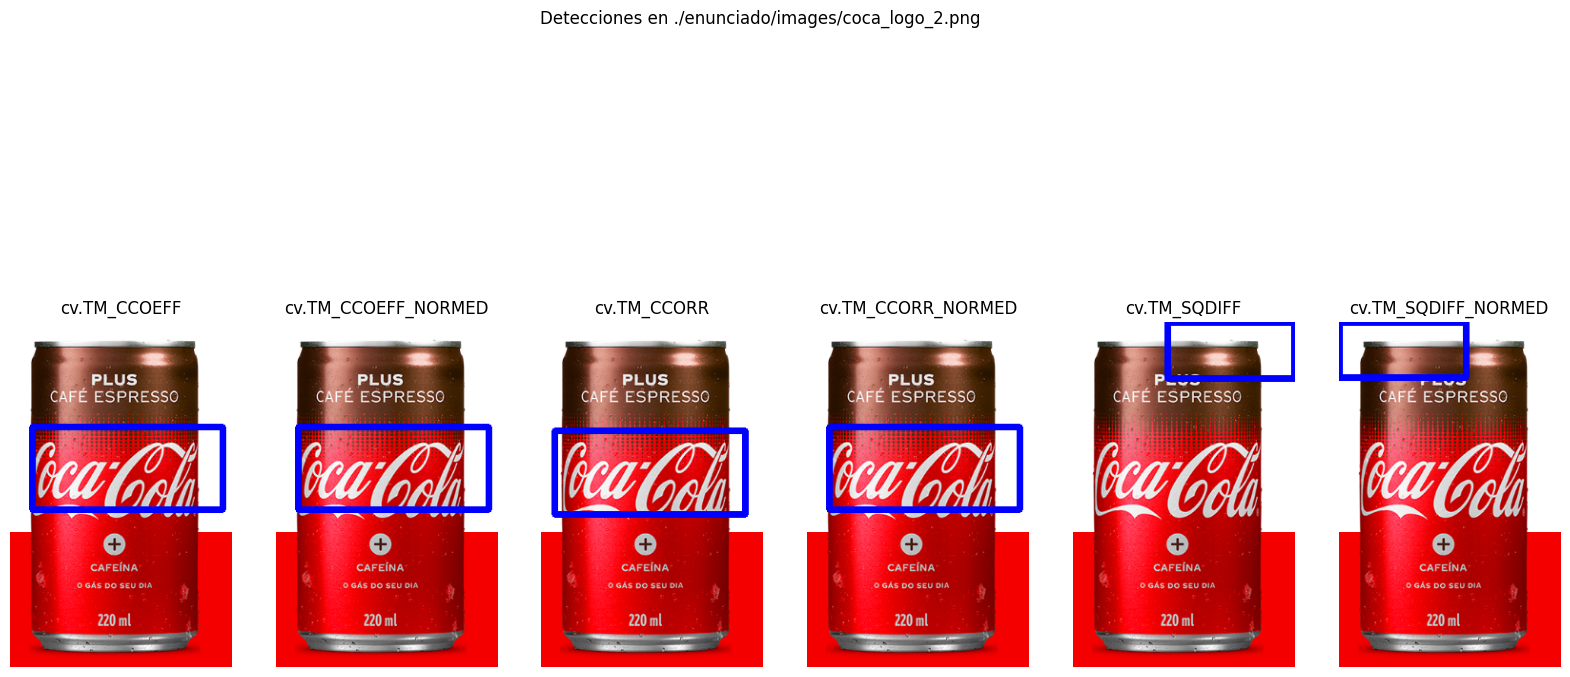

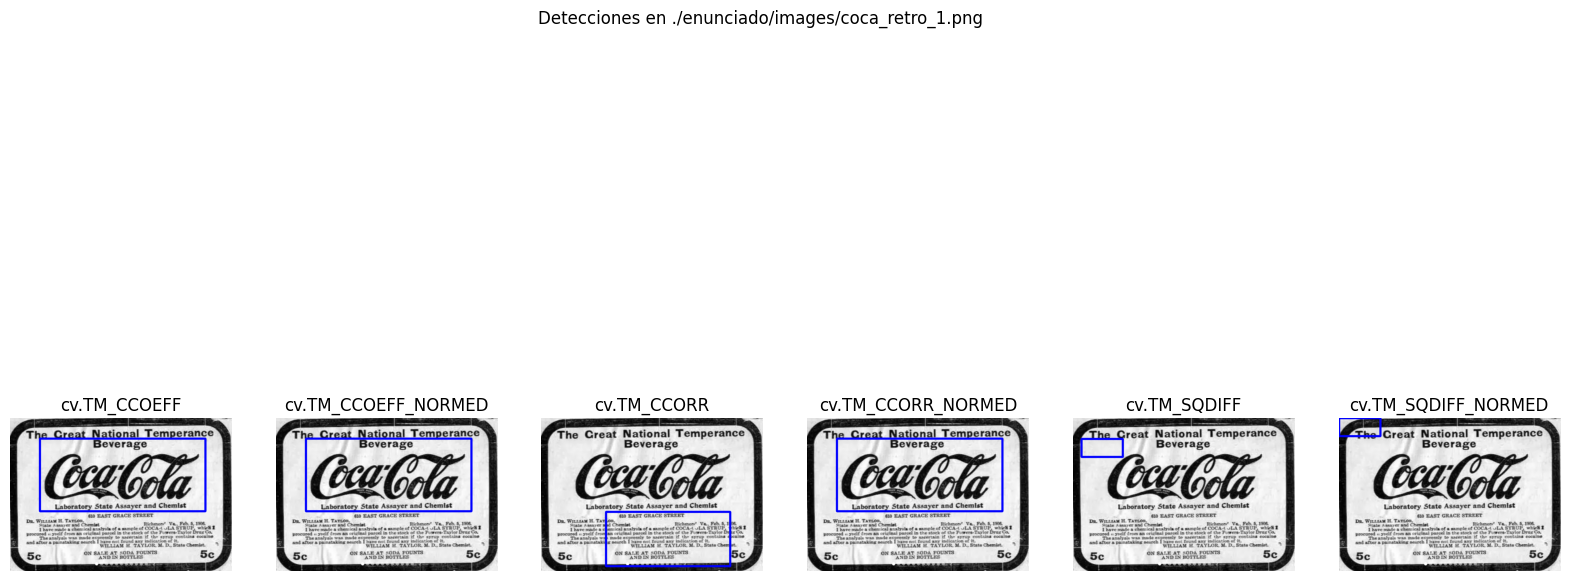

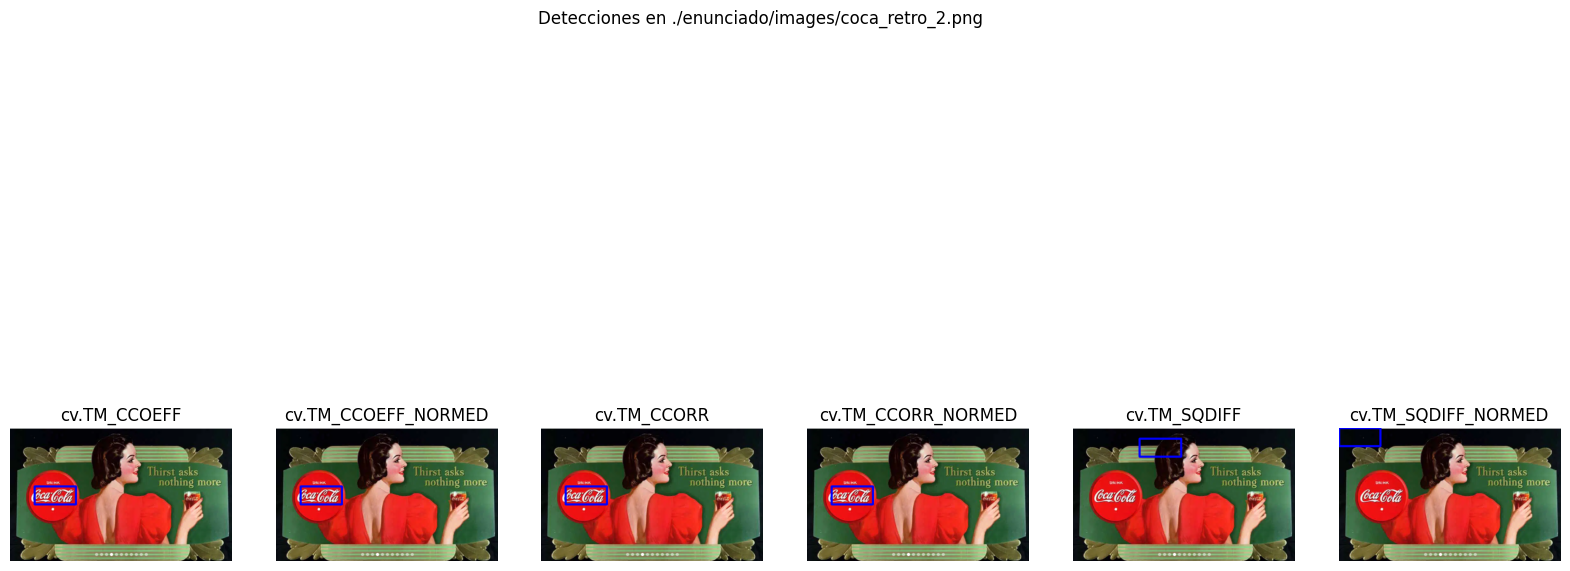

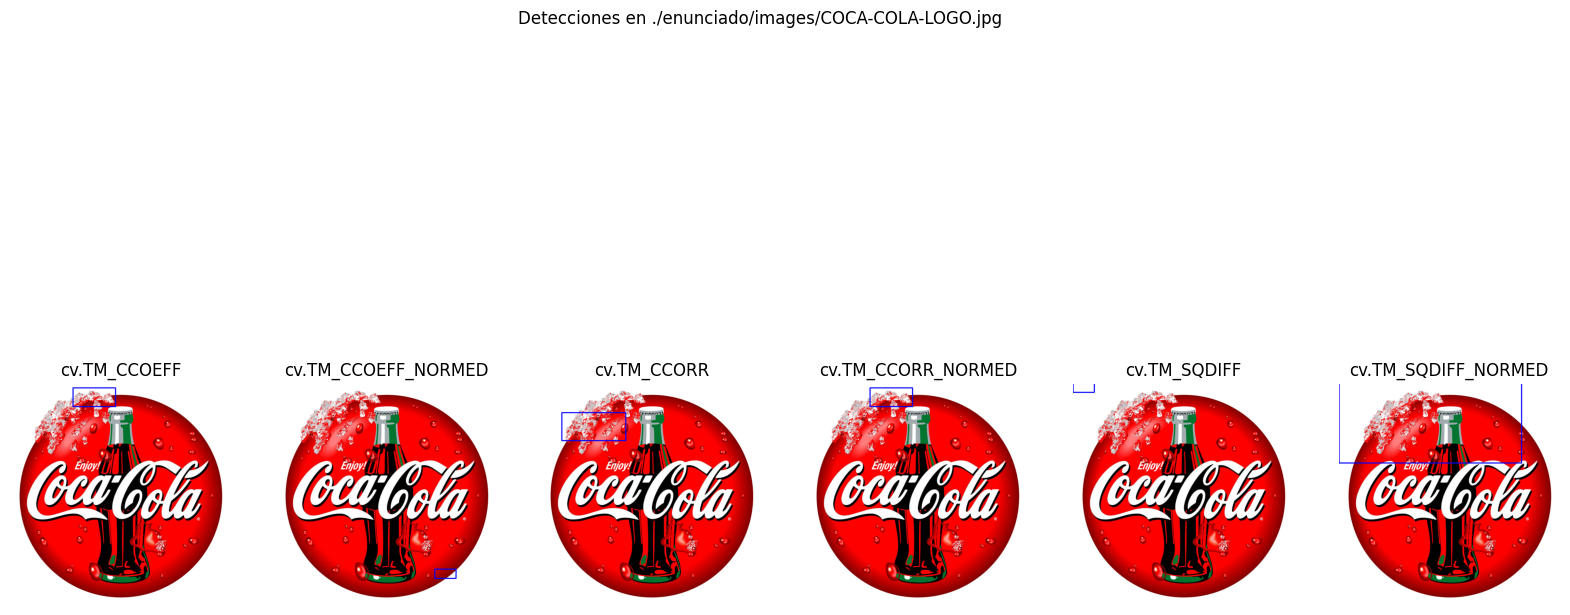

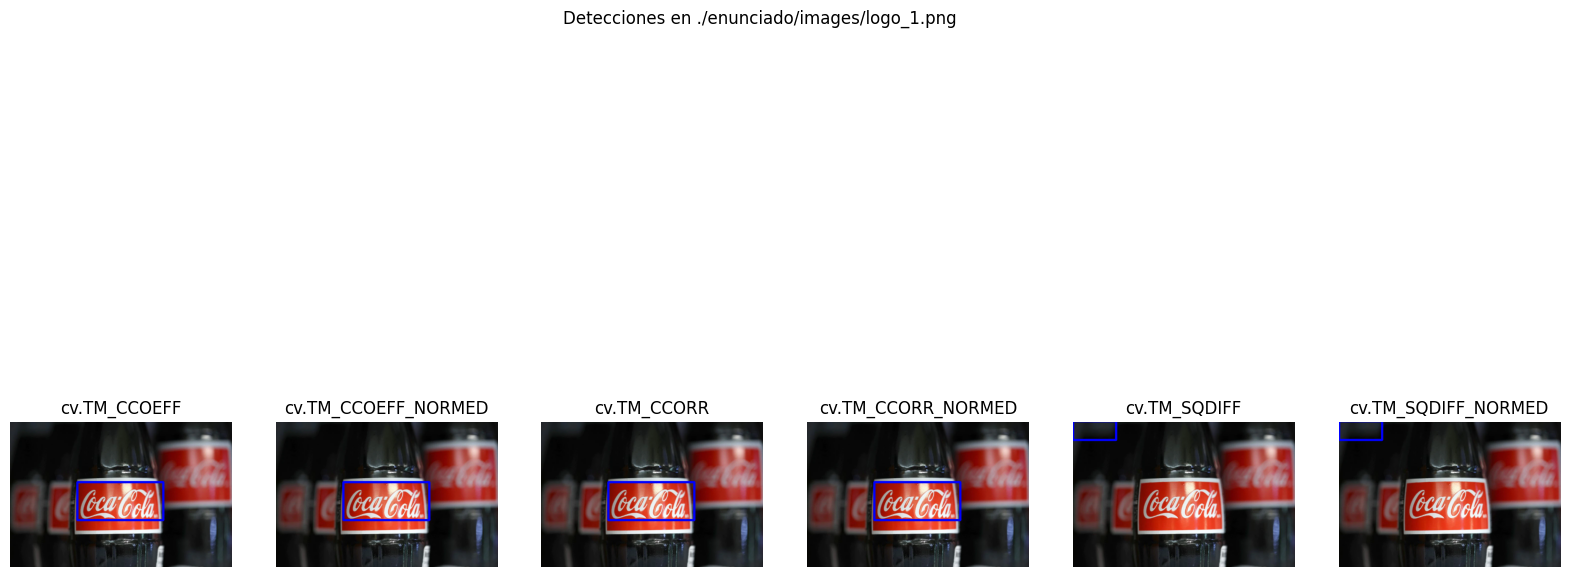

In [7]:
detect_logo_in_images(full_image_paths, template, methods, scales)


A continuacion agrego un poco mas de prints para debug, ya me voy a quedar solo con las de mayor confiaza

Confianza de la imagen: ./enunciado/images/coca_logo_1.png es: 1.00 / method: cv.TM_CCOEFF/scale: 2
Confianza de la imagen: ./enunciado/images/coca_logo_1.png es: 1.00 / method: cv.TM_CCOEFF_NORMED/scale: 2
Confianza de la imagen: ./enunciado/images/coca_logo_1.png es: 1.00 / method: cv.TM_CCORR/scale: 2
Confianza de la imagen: ./enunciado/images/coca_logo_1.png es: 1.00 / method: cv.TM_CCORR_NORMED/scale: 2
Confianza de la imagen: ./enunciado/images/coca_logo_1.png es: 0.06 / method: cv.TM_SQDIFF/scale: 3
Confianza de la imagen: ./enunciado/images/coca_logo_1.png es: 0.00 / method: cv.TM_SQDIFF_NORMED/scale: 3


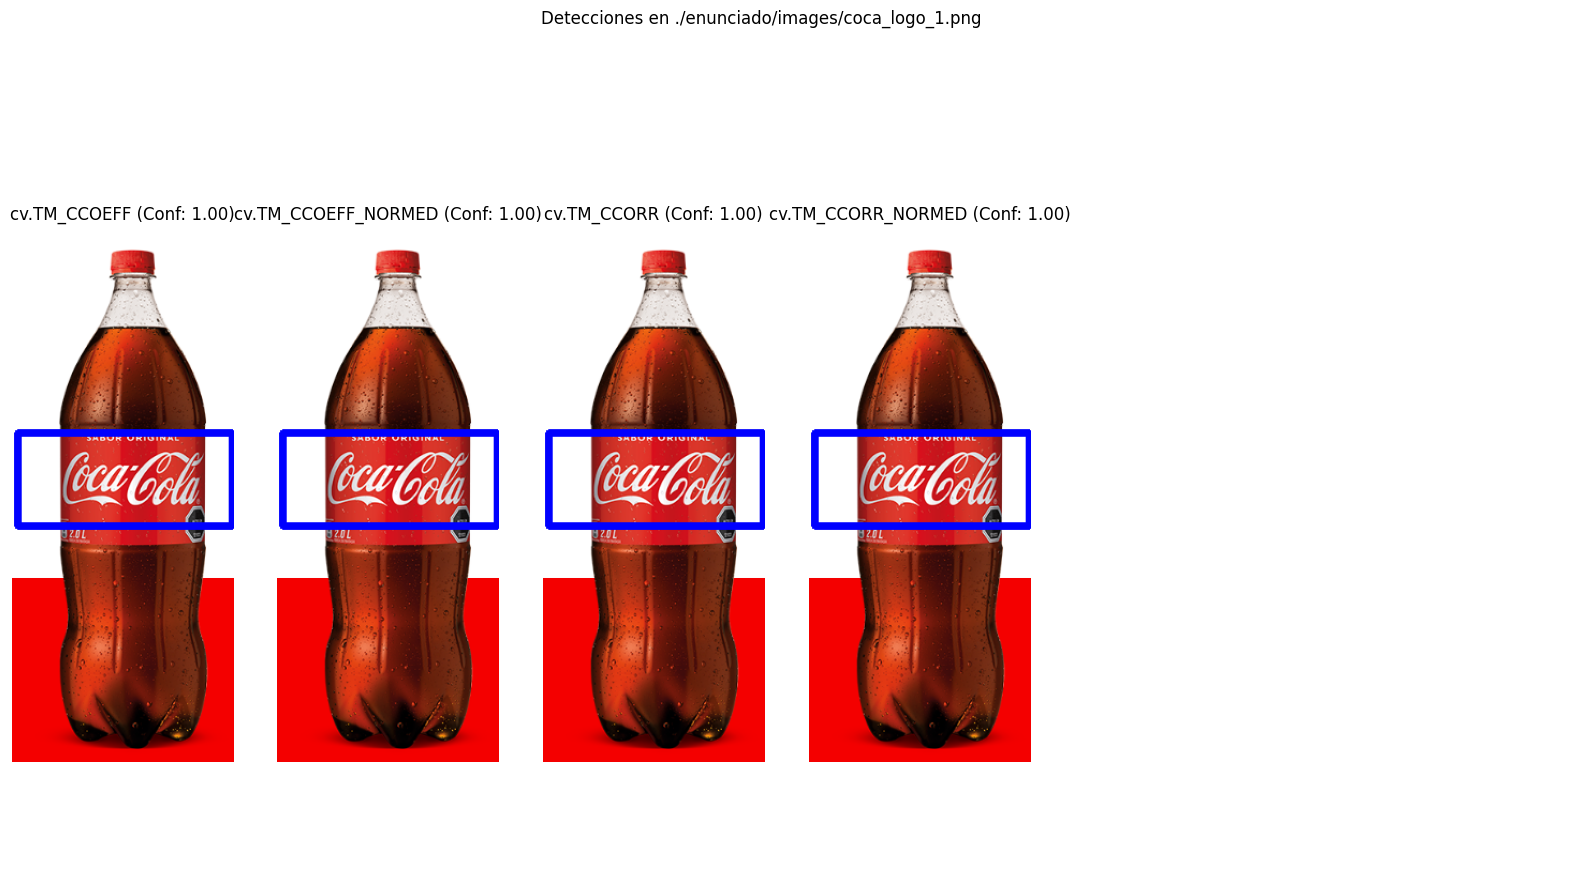

Confianza de la imagen: ./enunciado/images/coca_logo_2.png es: 1.00 / method: cv.TM_CCOEFF/scale: 2
Confianza de la imagen: ./enunciado/images/coca_logo_2.png es: 1.00 / method: cv.TM_CCOEFF_NORMED/scale: 2
Confianza de la imagen: ./enunciado/images/coca_logo_2.png es: 1.00 / method: cv.TM_CCORR/scale: 2
Confianza de la imagen: ./enunciado/images/coca_logo_2.png es: 1.00 / method: cv.TM_CCORR_NORMED/scale: 2
Confianza de la imagen: ./enunciado/images/coca_logo_2.png es: 0.12 / method: cv.TM_SQDIFF/scale: 3
Confianza de la imagen: ./enunciado/images/coca_logo_2.png es: 0.00 / method: cv.TM_SQDIFF_NORMED/scale: 3


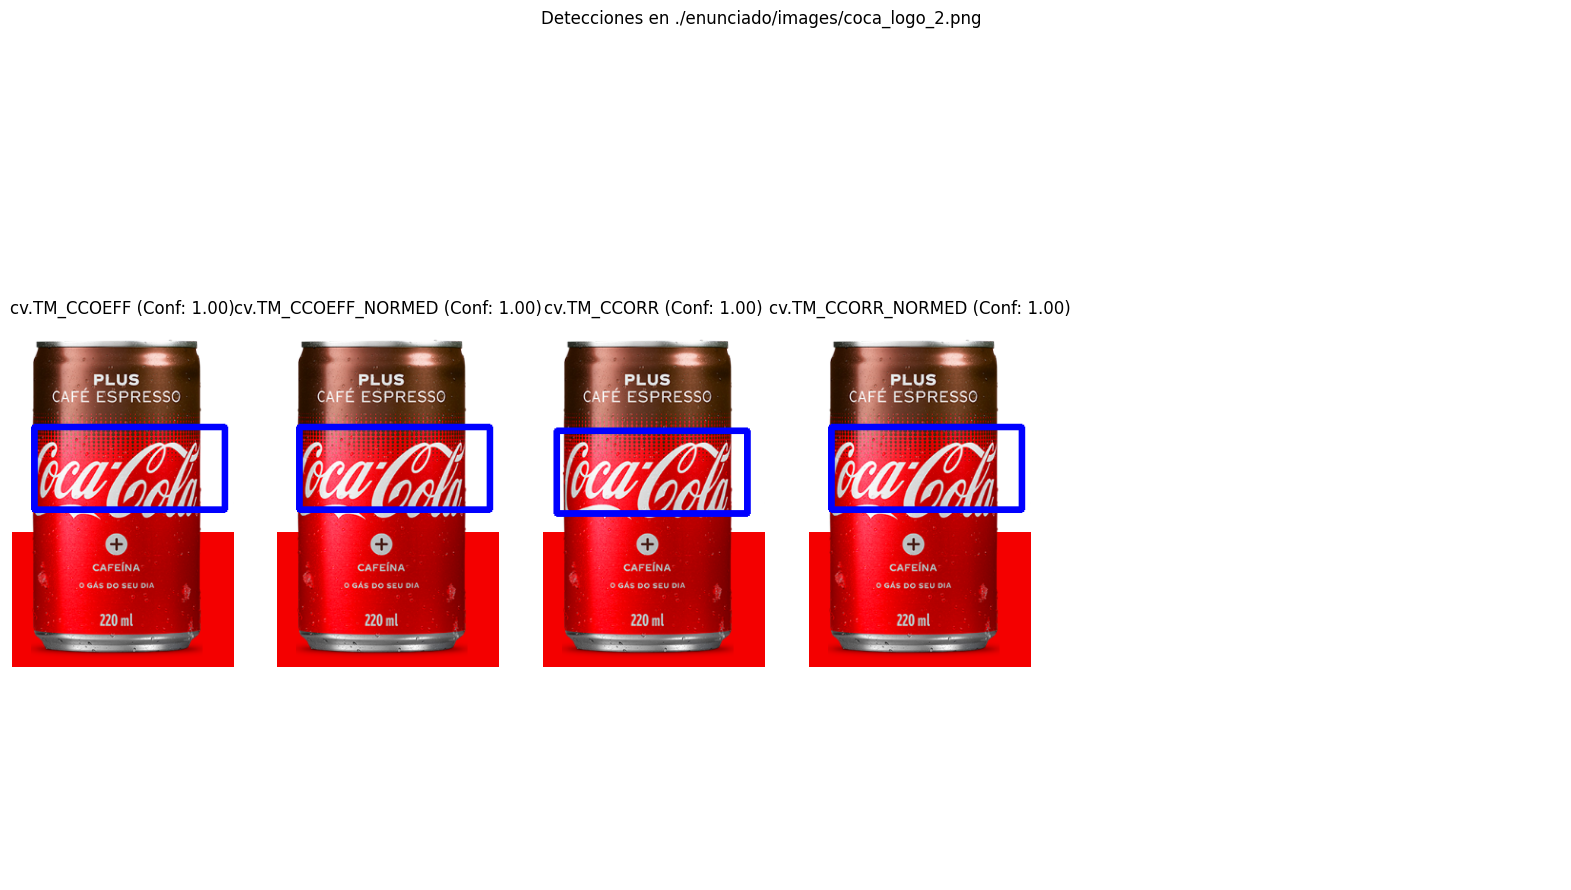

Confianza de la imagen: ./enunciado/images/coca_retro_1.png es: 1.00 / method: cv.TM_CCOEFF/scale: 0.75
Confianza de la imagen: ./enunciado/images/coca_retro_1.png es: 1.00 / method: cv.TM_CCOEFF_NORMED/scale: 0.75
Confianza de la imagen: ./enunciado/images/coca_retro_1.png es: 1.00 / method: cv.TM_CCORR/scale: 1
Confianza de la imagen: ./enunciado/images/coca_retro_1.png es: 1.00 / method: cv.TM_CCORR_NORMED/scale: 0.75
Confianza de la imagen: ./enunciado/images/coca_retro_1.png es: 0.50 / method: cv.TM_SQDIFF/scale: 3
Confianza de la imagen: ./enunciado/images/coca_retro_1.png es: 0.00 / method: cv.TM_SQDIFF_NORMED/scale: 3


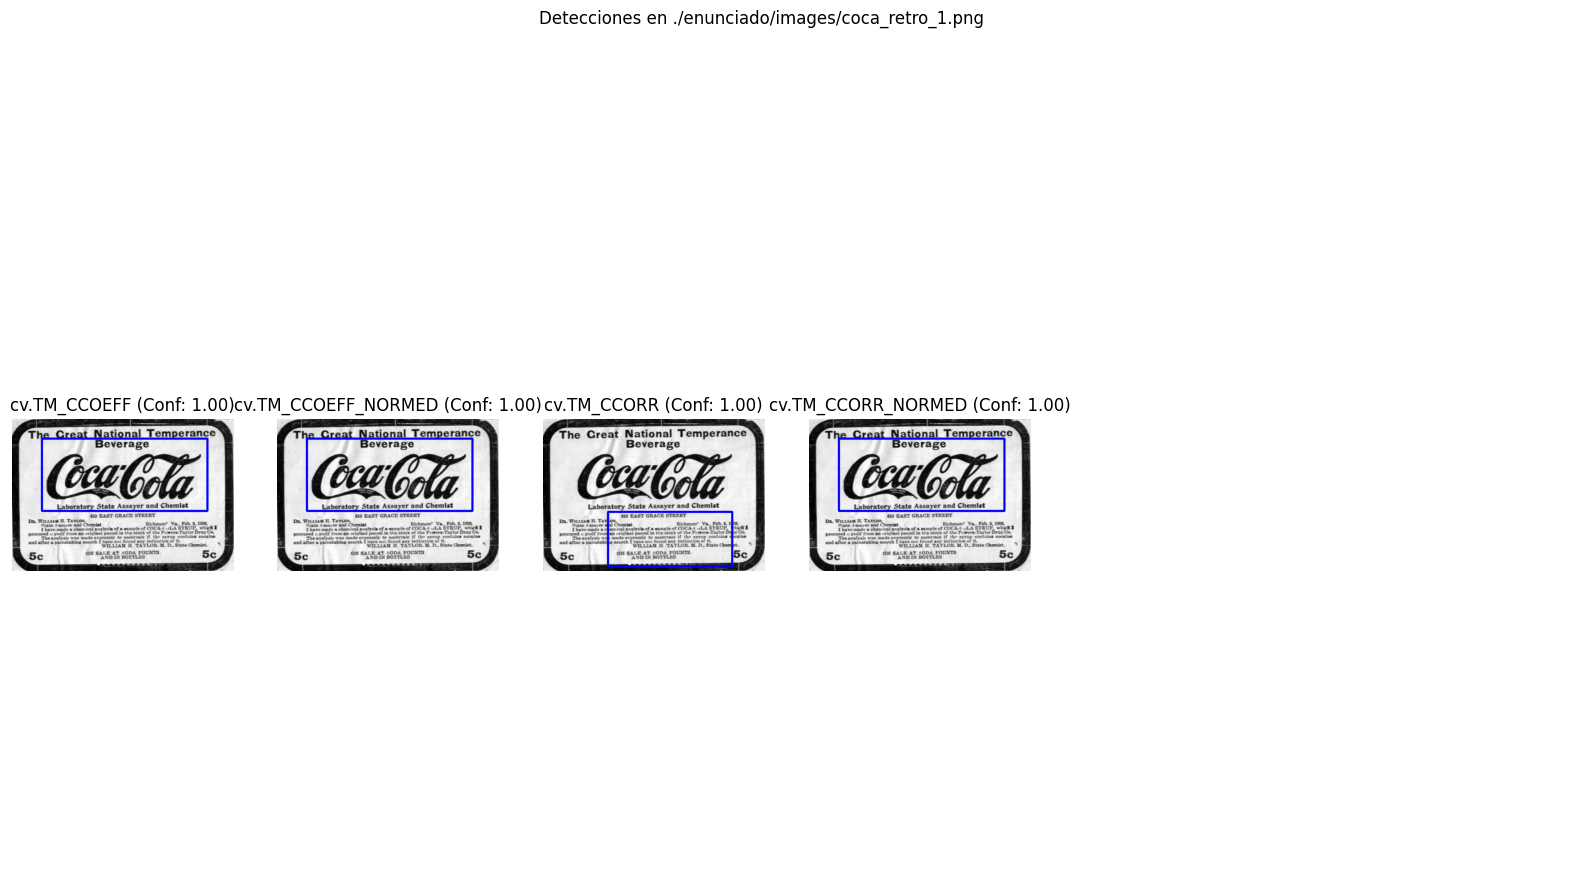

Confianza de la imagen: ./enunciado/images/coca_retro_2.png es: 1.00 / method: cv.TM_CCOEFF/scale: 3
Confianza de la imagen: ./enunciado/images/coca_retro_2.png es: 1.00 / method: cv.TM_CCOEFF_NORMED/scale: 3
Confianza de la imagen: ./enunciado/images/coca_retro_2.png es: 1.00 / method: cv.TM_CCORR/scale: 3
Confianza de la imagen: ./enunciado/images/coca_retro_2.png es: 1.00 / method: cv.TM_CCORR_NORMED/scale: 3
Confianza de la imagen: ./enunciado/images/coca_retro_2.png es: 0.37 / method: cv.TM_SQDIFF/scale: 3
Confianza de la imagen: ./enunciado/images/coca_retro_2.png es: 0.00 / method: cv.TM_SQDIFF_NORMED/scale: 3


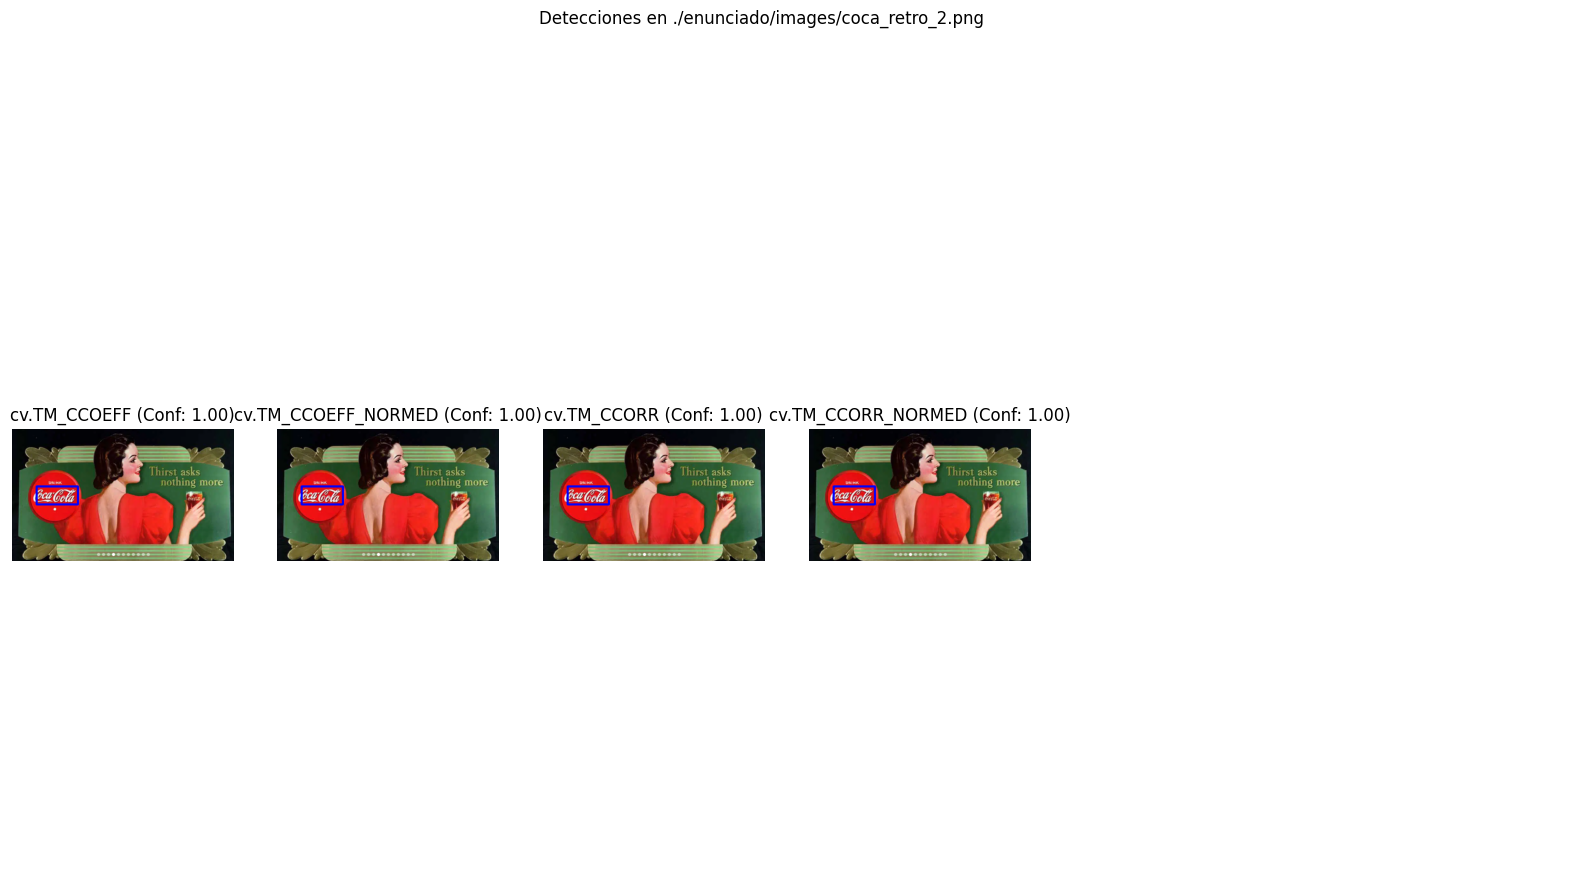

Confianza de la imagen: ./enunciado/images/COCA-COLA-LOGO.jpg es: 1.00 / method: cv.TM_CCOEFF/scale: 1.5
Confianza de la imagen: ./enunciado/images/COCA-COLA-LOGO.jpg es: 1.00 / method: cv.TM_CCOEFF_NORMED/scale: 3
Confianza de la imagen: ./enunciado/images/COCA-COLA-LOGO.jpg es: 1.00 / method: cv.TM_CCORR/scale: 1
Confianza de la imagen: ./enunciado/images/COCA-COLA-LOGO.jpg es: 1.00 / method: cv.TM_CCORR_NORMED/scale: 1.5
Confianza de la imagen: ./enunciado/images/COCA-COLA-LOGO.jpg es: 0.39 / method: cv.TM_SQDIFF/scale: 3
Confianza de la imagen: ./enunciado/images/COCA-COLA-LOGO.jpg es: 0.00 / method: cv.TM_SQDIFF_NORMED/scale: 0.35


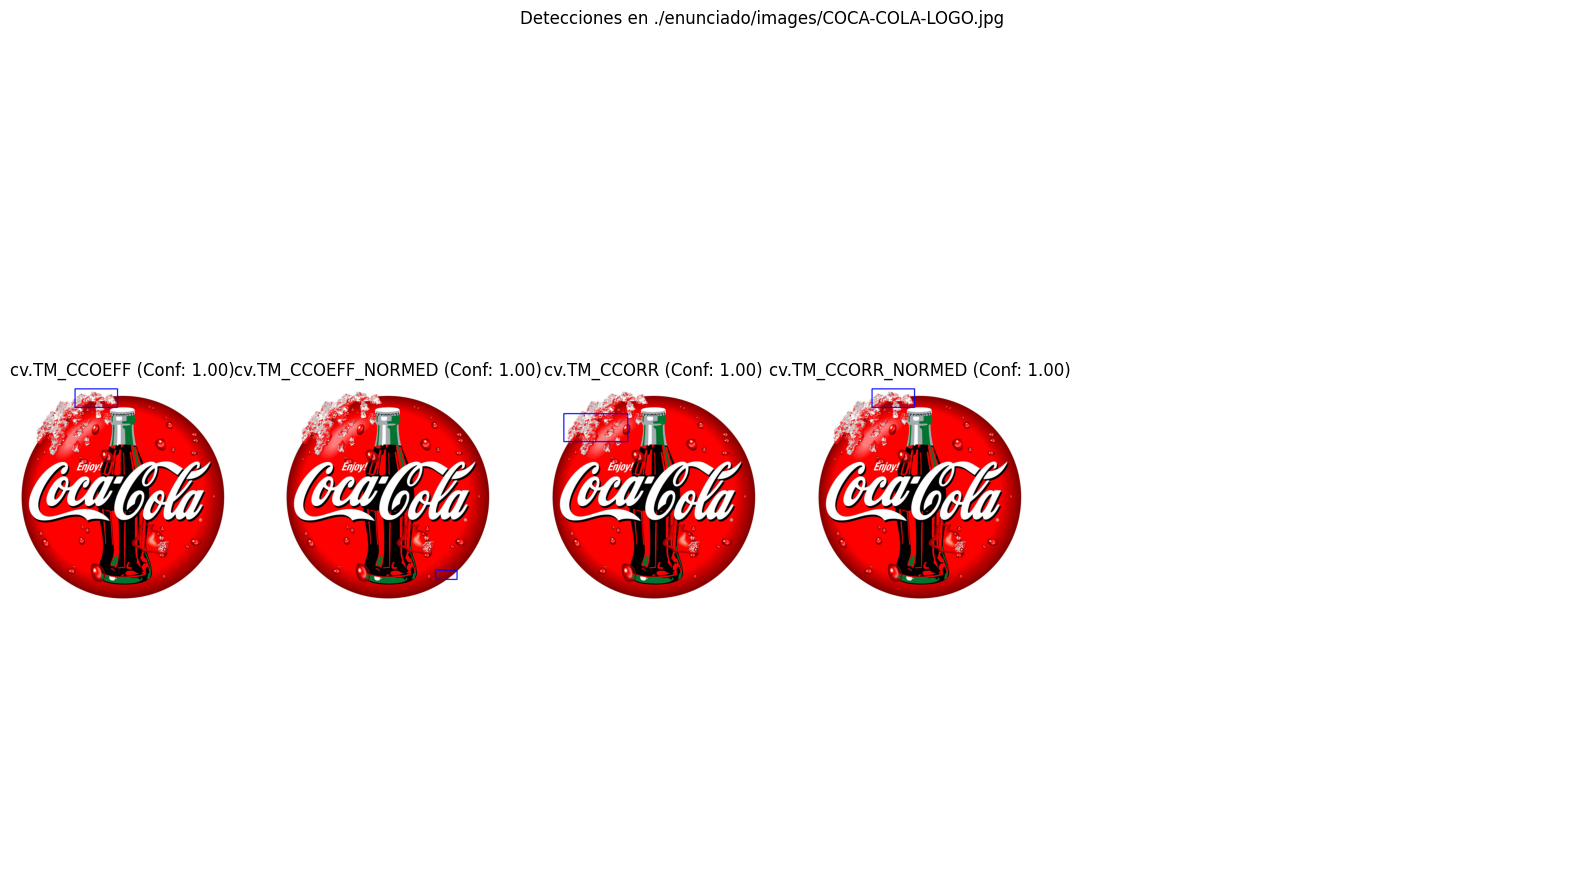

Confianza de la imagen: ./enunciado/images/logo_1.png es: 1.00 / method: cv.TM_CCOEFF/scale: 1.5
Confianza de la imagen: ./enunciado/images/logo_1.png es: 1.00 / method: cv.TM_CCOEFF_NORMED/scale: 1.5
Confianza de la imagen: ./enunciado/images/logo_1.png es: 1.00 / method: cv.TM_CCORR/scale: 1.5
Confianza de la imagen: ./enunciado/images/logo_1.png es: 1.00 / method: cv.TM_CCORR_NORMED/scale: 1.5
Confianza de la imagen: ./enunciado/images/logo_1.png es: 0.21 / method: cv.TM_SQDIFF/scale: 3
Confianza de la imagen: ./enunciado/images/logo_1.png es: 0.00 / method: cv.TM_SQDIFF_NORMED/scale: 3


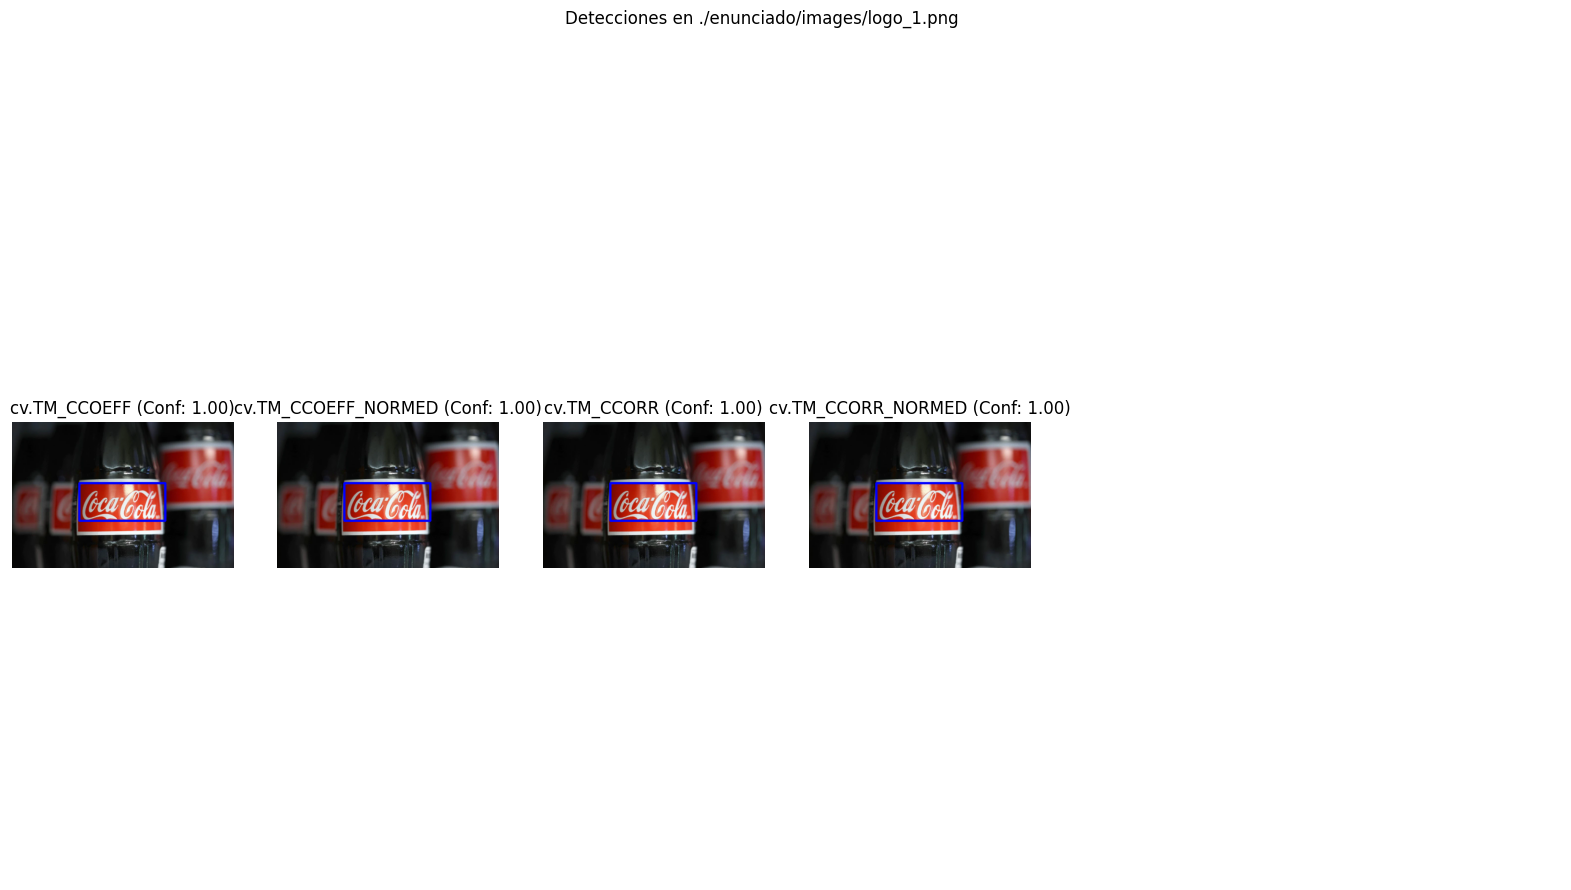

In [8]:
# Escalas a probar
scales = [0.35, 3, 2, 1.5, 1, 0.75, 0.5, 0.4, 0.25]

# Función para detectar el logo en las imágenes
def detect_logo_in_images(img_paths, template, methods, scales, threshold=0.5):
    h_template, w_template = template.shape[:2]

    for img_path in img_paths:
        img = cv.imread(img_path)
        if img is None:
            print(f"No se pudo cargar la imagen desde {img_path}")
            continue

        fig, axs = plt.subplots(1, 6, figsize=(20, 10))
        
        for j, meth in enumerate(methods):
            max_value = []
            max_local = []
            min_value = []
            min_local = []
            used_scales = []
            method = eval(meth)

            for scale in scales:
                img_rz = cv.resize(img, (int(img.shape[1] * scale), int(img.shape[0] * scale)))
                h_rz, w_rz = img_rz.shape[:2]
                if h_rz < h_template or w_rz < w_template:
                    continue

                image_gray = cv.cvtColor(img_rz, cv.COLOR_BGR2GRAY)
                img_canny = cv.Canny(image_gray, 100, 200)
                
                res = cv.matchTemplate(img_canny, template, method)
                min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)
                if method in [cv.TM_SQDIFF, cv.TM_SQDIFF_NORMED]:
                    min_value.append(min_val)
                    min_local.append(min_loc)
                else:
                    max_value.append(max_val)
                    max_local.append(max_loc)
                used_scales.append(scale)

            if method in [cv.TM_SQDIFF, cv.TM_SQDIFF_NORMED]:
                id = np.argmin(min_value)
                confidence = 1 - min_value[id] / np.max(min_value)
                local = min_local[id]
            else:
                id = np.argmax(max_value)
                confidence = max_value[id] / np.max(max_value)
                local = max_local[id]

            scale_used = used_scales[id]
            x, y = int(local[0] / scale_used), int(local[1] / scale_used)
            h_rectangle, w_rectangle = int(h_template / scale_used), int(w_template / scale_used)
            bottom_right = (x + w_rectangle, y + h_rectangle)
            top_left = (x, y)
            
            img_plot = img.copy()
            cv.rectangle(img_plot, top_left, bottom_right, (255, 0, 0), 5)
            
            title = f'{meth} (Conf: {confidence:.2f})'
            print(f"Confianza de la imagen: {img_path} es: {confidence:.2f} / method: {meth}/scale: {scale_used}")
            if confidence >= threshold:
                axs[j].imshow(cv.cvtColor(img_plot, cv.COLOR_BGR2RGB))
                axs[j].set_title(title)
                axs[j].axis('off')
            else:
                axs[j].axis('off')

        plt.suptitle(f'Detecciones en {img_path}')
        plt.show()



detect_logo_in_images(full_image_paths, template, methods, scales, threshold=0.5)


No tengo forma de poder sacar la imagen de coca: ./enunciado/images/COCA-COLA-LOGO.jpg en el formato automatico. 

Pasa algo con las escalas, porque con una escala de 0,35 anda bien sin drama -> adjunto evidencia y no encuentro q estoy haciendo mal. O porque cuando obtiene la confianza despues tose la verdad ... 


de todas formas veo que el que mejor va es el de TM_CCOEFF ...


Confianza de la imagen: ./enunciado/images/COCA-COLA-LOGO.jpg es: 1.00 / method: cv.TM_CCOEFF/scale: 0.35
Confianza de la imagen: ./enunciado/images/COCA-COLA-LOGO.jpg es: 1.00 / method: cv.TM_CCOEFF_NORMED/scale: 0.35
Confianza de la imagen: ./enunciado/images/COCA-COLA-LOGO.jpg es: 1.00 / method: cv.TM_CCORR/scale: 0.35
Confianza de la imagen: ./enunciado/images/COCA-COLA-LOGO.jpg es: 1.00 / method: cv.TM_CCORR_NORMED/scale: 0.35
Confianza de la imagen: ./enunciado/images/COCA-COLA-LOGO.jpg es: 0.00 / method: cv.TM_SQDIFF/scale: 0.35
Confianza de la imagen: ./enunciado/images/COCA-COLA-LOGO.jpg es: 0.00 / method: cv.TM_SQDIFF_NORMED/scale: 0.35


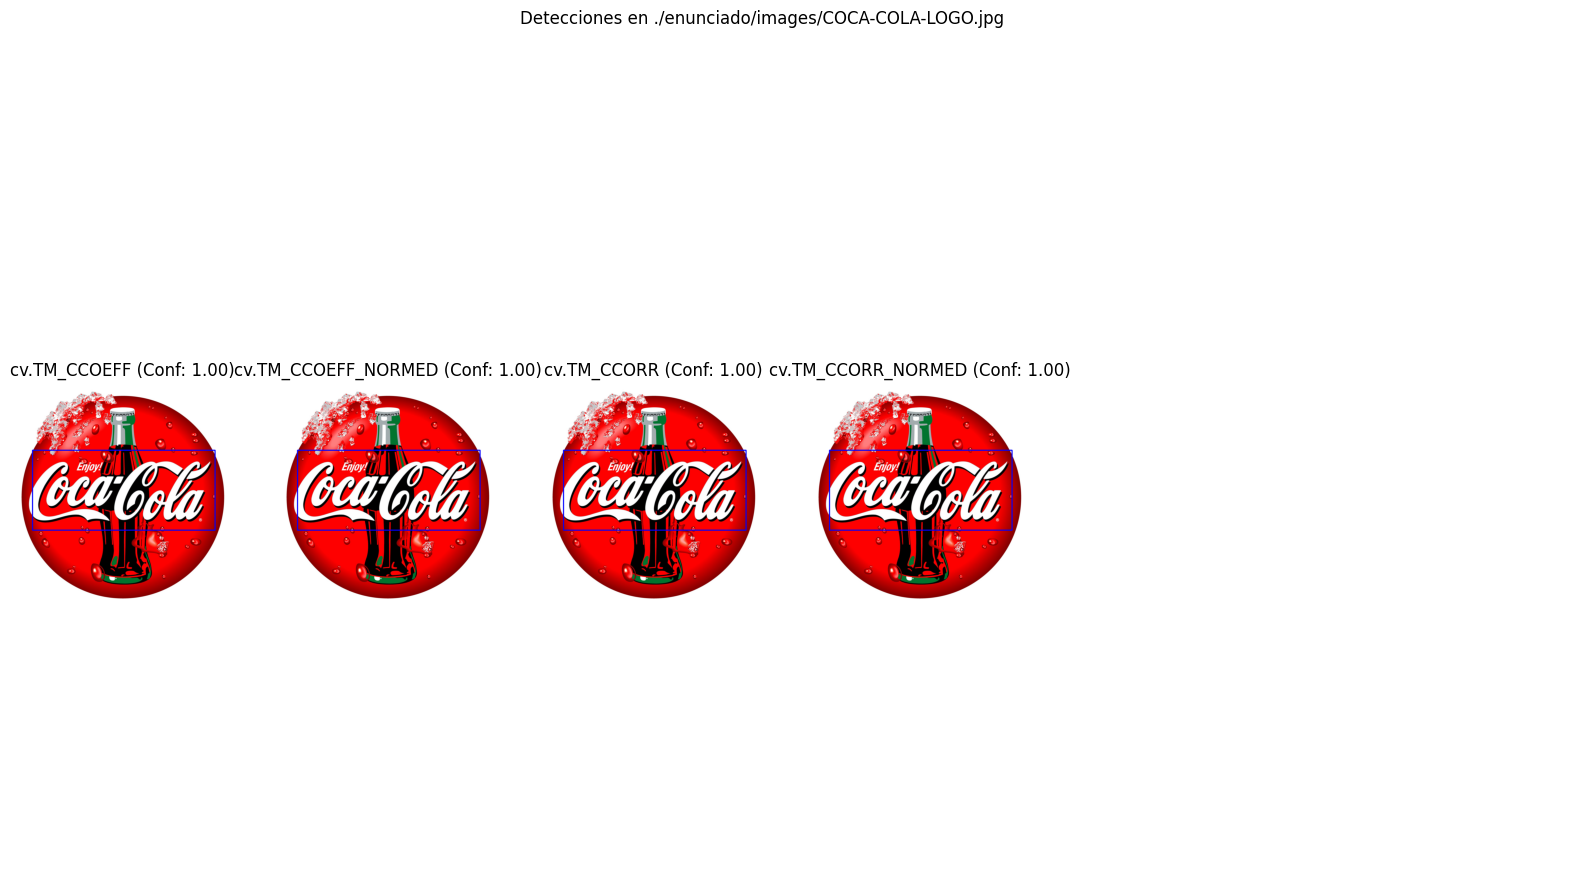

In [9]:
detect_logo_in_images([full_image_paths[4]], template, methods, [0.35], threshold=0.8)


--------


## REFACTORIZACION CODIGO 1

- cambio el enfoque de como quiero hacer la misma basado en estos pasos:

1. imagen a escala de grises
2. deteccion de bordes del temaplte con L2gradient esta vez
3. definicion de escalas automaticas. En vez de utilizar escalas fijas (va a tardar mas) pero le doy un maximo de factor.
4. busqueda por cada escala haciendo el resize correspondiente y aplicando canny a la imagen
5. calculo de la correlacion del template
6. manejo de umbral (voy a hacer q no se especifique de forma q se busquen todas las coincidencias)
7. mejor match y guardado de las coincidencias
8. retornar, no plotear aca es un quilombo


In [10]:
# Cargo librerias y paths
import cv2 as cv
import numpy as np
import os
import matplotlib.pyplot as plt
import math


# definiciones generales
base_path = './enunciado/images/'
image_files_single = ['coca_logo_1.png', 'coca_logo_2.png', 'coca_retro_1.png', 'coca_retro_2.png', 'COCA-COLA-LOGO.jpg', 'logo_1.png']

multi_image = 'coca_multi.png'
# template
template_path = './enunciado/template/pattern.png'

# lista de imagenes a procesar 
full_image_paths = [f"{base_path}{image_path}" for image_path in image_files_single]

Dimensiones del template: (175, 400)


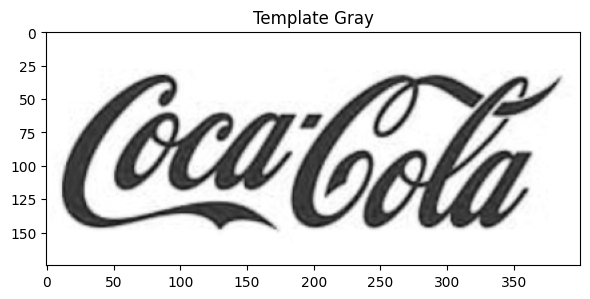

In [11]:
# Cargo el template y lo visualizo
template = cv.imread(template_path, cv.IMREAD_GRAYSCALE)
print(f"Dimensiones del template: {template.shape}")

# Visualizar el template en escala de grises
fig, axs = plt.subplots(1, 1, figsize=(6, 5))

axs.imshow(template, cmap='gray')
axs.set_title('Template Gray')
#axs.axis('off')

plt.tight_layout()
plt.show()

In [25]:
def detect_logo_in_images_new(image, template, match_threshold=None, method=cv.TM_CCOEFF):
    # convierto la imagen de entrada a escala de grises 
    gray_image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

    # aplico canny al template para detectar bordes
    template_edges = cv.Canny(template, 120, 240, L2gradient=True) #verificar los umbrales

    
    # defino los umbrales para crear la escala.
    # defino un maximo y luego se generan el minimo
    max_scale = 4
    min_scale = max (template.shape[0] / gray_image.shape[0], template.shape[1] / gray_image.shape[1])
    scale_factors = np.linspace(min_scale, max_scale, 100)

    optimal_match = None
    coincidences = []
    for scale in scale_factors:
        # escalo la imagen (si lo hago en el template pierdo definicion)
        scaled_image = cv.resize(gray_image, (0, 0), fx=scale, fy=scale, interpolation=cv.INTER_LINEAR) #buscar inter_linear
        scaled_edges = cv.Canny(scaled_image, 100, 200, L2gradient=True)
        
        # calculo la correlacion
        if template_edges.shape[0] < scaled_edges.shape[0] and template_edges.shape[1] < scaled_edges.shape[1]:
            correlation_result = cv.matchTemplate(scaled_edges, template_edges, method) #ya vimos q era el mejor antes
            min_val, max_val, min_loc, max_loc = cv.minMaxLoc(correlation_result)
            top_left = max_loc
            score = max_val
            width, height = template_edges.shape[::-1]

            # ahora veo el caso si tengo varias coincidencias, es decir
            # si ponemos un threshold, tenemos que buscar todos los matches mayores a match_threshold*max_val en la escala en la q se trabaja
            if match_threshold is not None:
                locations = np.where(correlation_result >= match_threshold * max_val)
                for loc in zip(*locations[::-1]):
                    coincidences.append((correlation_result[loc[1], loc[0]], (loc[0], loc[1]), (loc[0] + width, loc[1] + height), scale))

            # guarlo la mejor coincidencia
            if optimal_match is None or score > optimal_match[0]:
                bottom_right = (max_loc[0] + width, max_loc[1] + height)
                optimal_match = (score, top_left, bottom_right, scale)
                

    if match_threshold is not None:
        # busco la coincidencia óptima (con el puntaje más alto)
        optimal_match = max(coincidences, key=lambda x: x[0])

        # filtro las coincidencias que cumplan con el umbral de coincidencia
        filtered_coincidences = []
        for match in coincidences:
            if match[0] >= match_threshold * optimal_match[0]:
                filtered_coincidences.append(match)

        # ordeno las coincidencias filtradas por puntaje de mayor a menor
        filtered_coincidences.sort(key=lambda x: x[0], reverse=True)
        
        return filtered_coincidences
    else:
        return optimal_match

In [13]:
def display_detection_results(image, detections, image_name):
    # Convertir la imagen a RGB
    image_rgb = cv.cvtColor(image, cv.COLOR_BGR2RGB)

    # Verificar si el primer elemento es un float, lo que indica una sola detección
    if isinstance(detections[0], float):
        scale_factor = detections[3]
        top_left = (round(detections[1][0] / scale_factor), round(detections[1][1] / scale_factor))
        bottom_right = (round(detections[2][0] / scale_factor), round(detections[2][1] / scale_factor))
        cv.rectangle(image_rgb, top_left, bottom_right, (0, 255, 0), 2)
    else:
        for detection in detections:
            scale_factor = detection[3]
            top_left = (round(detection[1][0] / scale_factor), round(detection[1][1] / scale_factor))
            bottom_right = (round(detection[2][0] / scale_factor), round(detection[2][1] / scale_factor))
            cv.rectangle(image_rgb, top_left, bottom_right, (0, 255, 0), 2)

    # Crear una figura y ejes para el plot
    plt.figure(figsize=(6, 6))
    plt.imshow(image_rgb)
    plt.title(f'Deteccion img: {image_name}')
    plt.show()

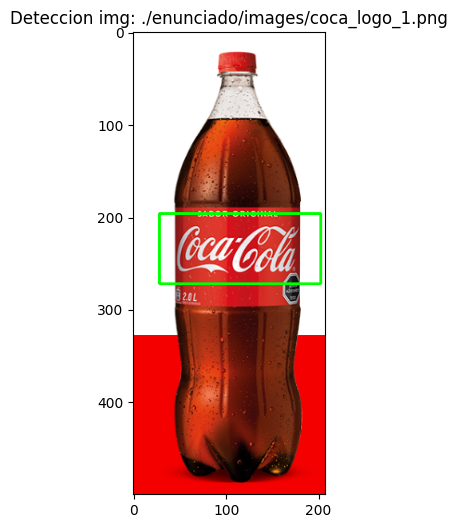

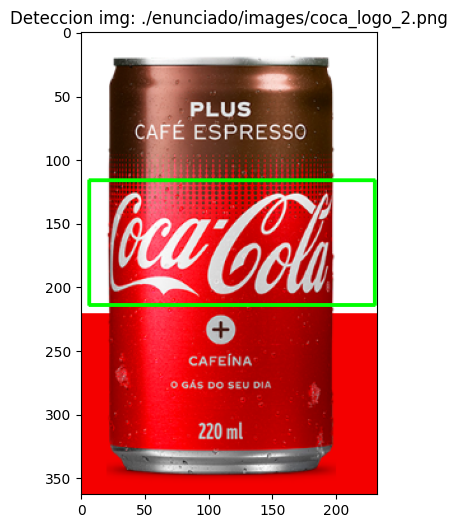

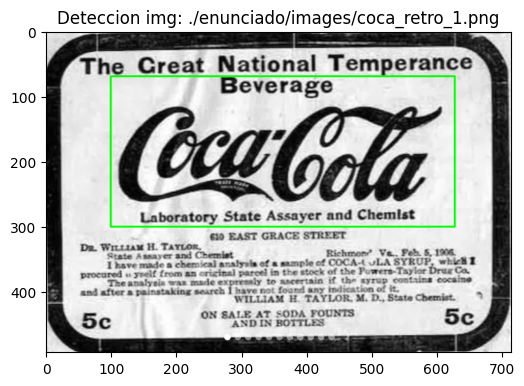

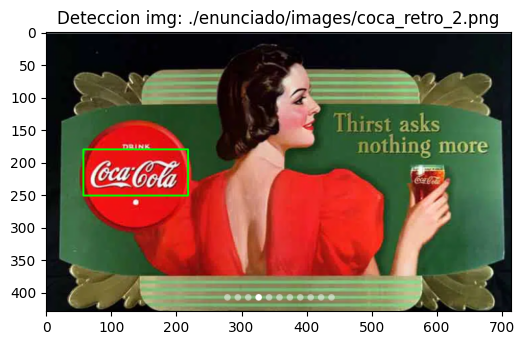

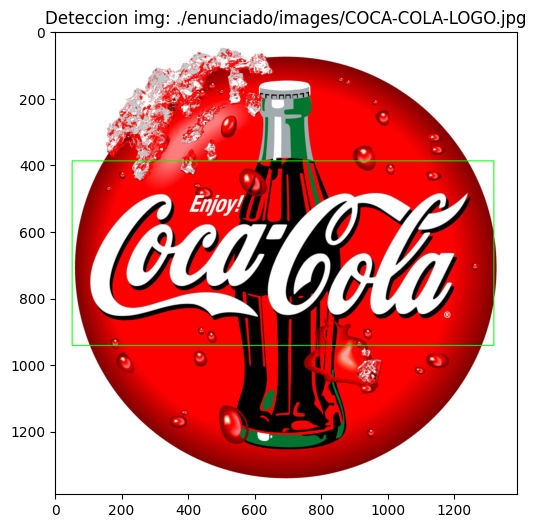

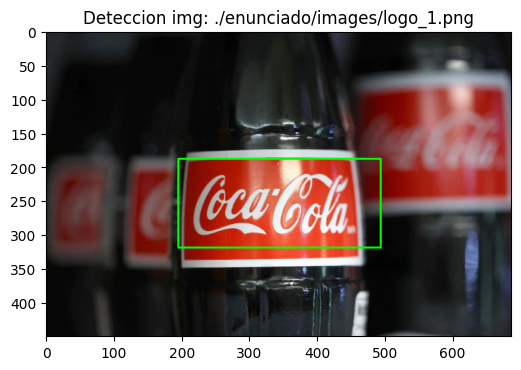

In [14]:
for imagen in full_image_paths:
    img = cv.imread(imagen)
    matches = detect_logo_in_images_new(img, template)
    display_detection_results (img, matches, imagen)

### parte 2

vamos a tener q modificar un poco por el overlap posiblemente

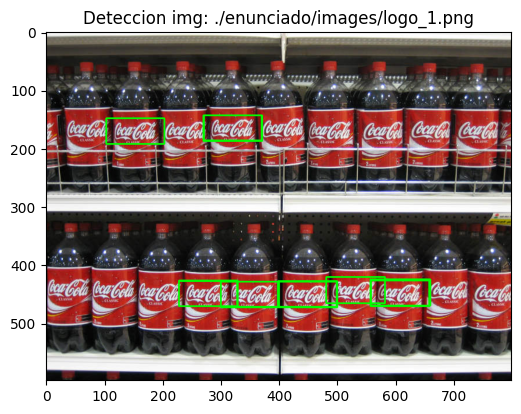

In [26]:
template = cv.imread(template_path, cv.IMREAD_GRAYSCALE)

coca_multi = base_path+multi_image


img = cv.imread(coca_multi)
matches = detect_logo_in_images_new(img, template, method=cv.TM_CCOEFF_NORMED,match_threshold = 0.83) #cambie el tipo de metodo, mas bajo capaz q da mas falsos postivos 
display_detection_results (img, matches, imagen)